In [1]:
!pip3 install requests pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

/Users/brunoinzunza/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
#Polygon API key
API_KEY = 'api-key'

In [4]:
def fetch_forex_data(symbol, start_date, end_date):
    """
    Fetch Forex data from Polygon.io and return it as a pandas DataFrame.
    
    Parameters:
        symbol (str): Forex symbol to fetch data for (e.g., 'EURUSD').
        start_date (str): Start date for the data in 'YYYY-MM-DD' format.
        end_date (str): End date for the data in 'YYYY-MM-DD' format.
    
    Returns:
        pd.DataFrame: DataFrame containing Forex data.
    """
    
    url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/minute/{start_date}/{end_date}'
    params = {
        'apiKey': API_KEY
    }
    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        raise Exception(f"Error fetching data: {response.status_code}, {response.text}")
    
    data = response.json()
    
    # Convert to DataFrame
    if 'results' in data:
        df = pd.DataFrame(data['results'])
        df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df.rename(columns={
            'o': 'open',
            'h': 'high',
            'l': 'low',
            'c': 'close',
            'v': 'volume'
        }, inplace=True)
        df.sort_index(inplace=True)
        return df
    else:
        raise Exception("No data found")

In [5]:
def three_moving_average_strategy(data, short_window=1, medium_window=5, long_window=25):
    """
    Implements a trading strategy based on three moving averages.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing 'open', 'high', 'low', 'close', 'volume' columns.
        short_window (int): The period for the short moving average.
        medium_window (int): The period for the medium moving average.
        long_window (int): The period for the long moving average.
    
    Returns:
        pd.DataFrame: DataFrame with trading signals.
    """
    signals = pd.DataFrame(index=data.index)
    signals['close'] = data['close']
    signals['short_mavg'] = data['close'].rolling(window=short_window, min_periods=1).mean()
    signals['medium_mavg'] = data['close'].rolling(window=medium_window, min_periods=1).mean()
    signals['long_mavg'] = data['close'].rolling(window=long_window, min_periods=1).mean()
    
    signals['signal'] = 0.0
    signals['signal'][short_window:] = np.where(
        (signals['short_mavg'][short_window:] > signals['medium_mavg'][short_window:]) &
        (signals['medium_mavg'][short_window:] > signals['long_mavg'][short_window:]),
        0.0, 1.0
    )
    
    signals['positions'] = signals['signal'].diff()
    
    return signals

In [6]:
def backtest_strategy(data, signals):
    """
    Backtests the trading strategy and computes performance metrics.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing 'open', 'high', 'low', 'close', 'volume' columns.
        signals (pd.DataFrame): DataFrame containing trading signals.
    
    Returns:
        pd.DataFrame: DataFrame with trade details.
        float: Win rate.
        float: Risk-to-reward ratio.
        float: Average trades per hour.
        list: List of PnL values.
    """
    trades = []
    balance = 10000  # Initial balance
    position = None
    entry_price = None
    stop_loss = None
    take_profit = None
    
    for i in range(1, len(signals)):
        if signals['positions'].iloc[i] == 1 and position is None:
            # Enter long position
            position = 'long'
            entry_price = data['close'].iloc[i]
            stop_loss = entry_price * 0.99  # 1% stop loss
            take_profit = entry_price * 1.01  # 1% take profit
        
        elif signals['positions'].iloc[i] == -1 and position is not None:
            # Exit position
            exit_price = data['close'].iloc[i]
            pnl = exit_price - entry_price
            trades.append({
                'entry_time': data.index[i],
                'entry_price': entry_price,
                'exit_time': data.index[i],
                'exit_price': exit_price,
                'pnl': pnl
            })
            balance += pnl
            position = None
            entry_price = None
        
        elif position == 'long':
            # Check for stop loss or take profit
            if data['close'].iloc[i] <= stop_loss or data['close'].iloc[i] >= take_profit:
                exit_price = data['close'].iloc[i]
                pnl = exit_price - entry_price
                trades.append({
                    'entry_time': data.index[i],
                    'entry_price': entry_price,
                    'exit_time': data.index[i],
                    'exit_price': exit_price,
                    'pnl': pnl
                })
                balance += pnl
                position = None
                entry_price = None
    
    trades_df = pd.DataFrame(trades)
    
    # Calculate metrics
    pnl_list = trades_df['pnl'].tolist()
    win_trades = len(trades_df[trades_df['pnl'] > 0])
    loss_trades = len(trades_df[trades_df['pnl'] <= 0])
    
    if len(trades_df) > 0:
        win_rate = (win_trades / len(trades_df)) * 100
        risk_reward_ratio = (sum(trades_df[trades_df['pnl'] > 0]['pnl']) / -sum(trades_df[trades_df['pnl'] < 0]['pnl'])) if loss_trades > 0 else float('inf')
    else:
        win_rate = 0
        risk_reward_ratio = 0
    
    # Calculate trades per hour
    trades_per_hour = len(trades_df) / ((data.index[-1] - data.index[0]).total_seconds() / 3600)
    
    return trades_df, win_rate, risk_reward_ratio, trades_per_hour, pnl_list


In [7]:
import seaborn as sns

def plot_results(trades_df, pnl_list):
    """
    Plot the PnL graph and display performance metrics.
    
    Parameters:
        trades_df (pd.DataFrame): DataFrame with trade details.
        pnl_list (list): List of PnL values.
    """
    # Plot cumulative PnL chart
    plt.figure(figsize=(14, 7))
    plt.plot(pd.Series(pnl_list).cumsum(), label='Cumulative PnL')
    plt.xlabel('Trades')
    plt.ylabel('Cumulative PnL')
    plt.title('Cumulative PnL Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot trade returns
    plt.figure(figsize=(14, 7))
    plt.plot(trades_df['entry_time'], trades_df['pnl'], 'o', label='Trade Returns')
    plt.xlabel('Trade Entry Time')
    plt.ylabel('Trade PnL')
    plt.title('Trade Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Number of winners vs losers
    win_trades = len(trades_df[trades_df['pnl'] > 0])
    loss_trades = len(trades_df[trades_df['pnl'] <= 0])
    plt.figure(figsize=(8, 6))
    sns.barplot(x=['Winners', 'Losers'], y=[win_trades, loss_trades])
    plt.xlabel('Trade Type')
    plt.ylabel('Number of Trades')
    plt.title('Number of Winning vs Losing Trades')
    plt.show()

    # Print metrics
    total_trades = len(trades_df)
    win_rate = (win_trades / total_trades) * 100 if total_trades > 0 else 0
    risk_reward_ratio = (sum(trades_df[trades_df['pnl'] > 0]['pnl']) / -sum(trades_df[trades_df['pnl'] < 0]['pnl'])) if loss_trades > 0 else float('inf')
    average_trades_per_hour = trades_per_hour

    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Risk-Reward Ratio: {risk_reward_ratio:.2f}")
    print(f"Average Trades Per Hour: {average_trades_per_hour:.2f}")

    # Print trade details table
    print("\nTrade Details:")
    print(trades_df[['entry_time', 'exit_time', 'entry_price', 'exit_price', 'pnl']])


/var/folders/b_/rf0bpmls55x3h72ntzc7330m0000gn/T/ipykernel_94815/3985614949.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_window:] = np.where(


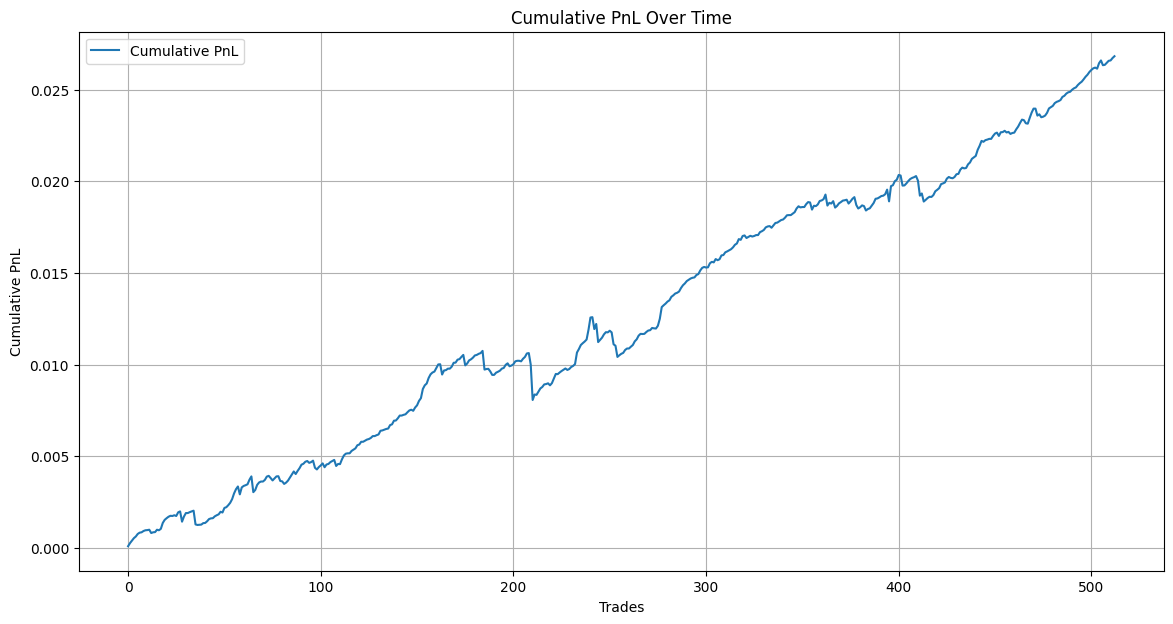

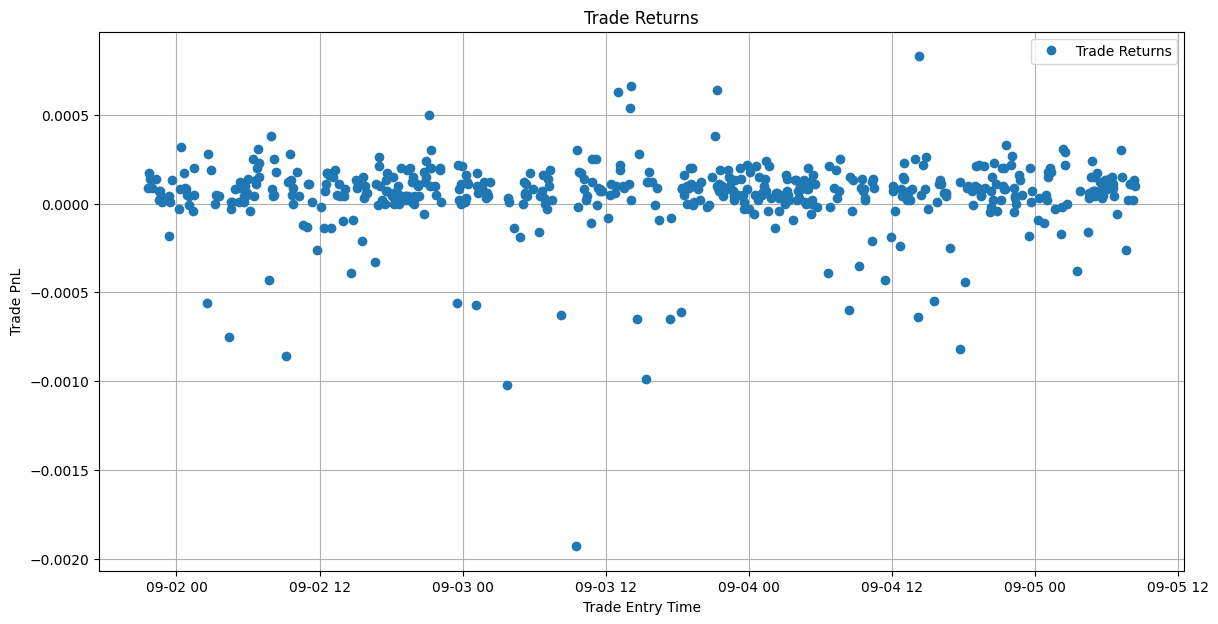

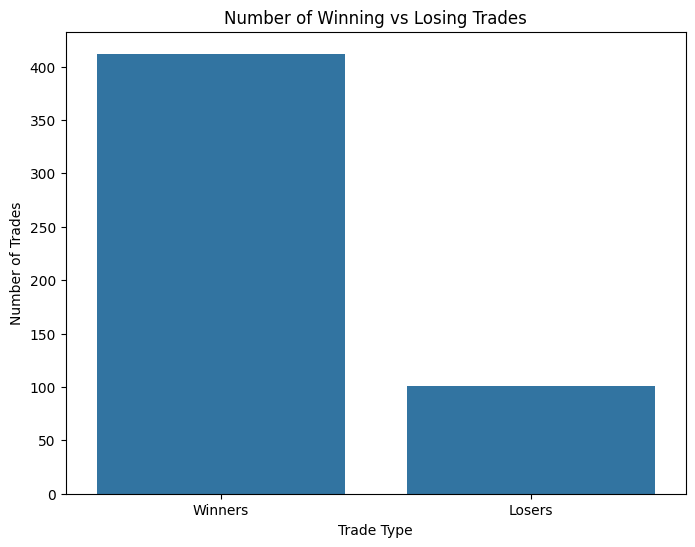

Win Rate: 80.31%
Risk-Reward Ratio: 2.28
Average Trades Per Hour: 6.14

Trade Details:
             entry_time           exit_time  entry_price  exit_price      pnl
0   2024-09-01 21:39:00 2024-09-01 21:39:00      1.10466     1.10475  0.00009
1   2024-09-01 21:44:00 2024-09-01 21:44:00      1.10461     1.10478  0.00017
2   2024-09-01 21:47:00 2024-09-01 21:47:00      1.10462     1.10476  0.00014
3   2024-09-01 21:50:00 2024-09-01 21:50:00      1.10466     1.10479  0.00013
4   2024-09-01 21:57:00 2024-09-01 21:57:00      1.10468     1.10477  0.00009
..                  ...                 ...          ...         ...      ...
508 2024-09-05 07:58:00 2024-09-05 07:58:00      1.10845     1.10856  0.00011
509 2024-09-05 08:02:00 2024-09-05 08:02:00      1.10847     1.10858  0.00011
510 2024-09-05 08:14:00 2024-09-05 08:14:00      1.10924     1.10926  0.00002
511 2024-09-05 08:21:00 2024-09-05 08:21:00      1.10937     1.10950  0.00013
512 2024-09-05 08:24:00 2024-09-05 08:24:00      1.1093

In [8]:
# Fetch data
symbol = 'C:EURUSD'
start_date = '2024-09-01'
end_date = '2024-09-30'
data = fetch_forex_data(symbol, start_date, end_date)

# Apply strategy
signals = three_moving_average_strategy(data)

# Backtest strategy
trades_df, win_rate, risk_reward_ratio, trades_per_hour, pnl_list = backtest_strategy(data, signals)

# Plot results
plot_results(trades_df, pnl_list)
